# 初期設定

In [1]:
#必要なライブラリインポート
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

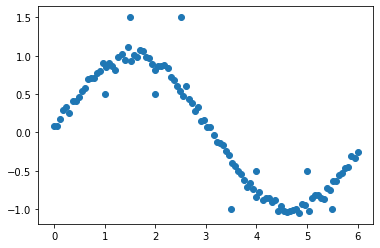

In [2]:
#適当なデータ作る
np.random.seed(0)
n = 100
X = np.linspace(0, 6, n)
y = np.sin(X) + np.random.randn(n) / 20

#外れ値入れてみる
X = np.concatenate([X, [1, 2, 4, 5, 1.5, 2.5, 3.5, 5.5]])
y = np.concatenate([y, [0.5, 0.5, -0.5, -0.5, 1.5, 1.5, -1, -1]])

#グラフ作成
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(X, y)
plt.show()

# 勾配ブースティング（自作）

勾配ブースティングに使う決定木は、scikit-learnのやつ借りる

In [3]:
from sklearn.tree import DecisionTreeRegressor # 決定木

In [4]:
n = 100         #ループ回数
learn_r = 0.1  #学習率
sample_r = 0.5 #ツリー作成時のサンプル使用率

In [5]:
# 誤差関数: 残差平方和(Least squares)
def get_loss(ys, y_preds):
    return sum([(y - y_pred) ** 2 for y, y_pred in zip(ys, y_preds)])

get_loss(ys=[0, 1, 2], y_preds=[5, 4, 3])

35

In [6]:
# 誤差関数の導関数
def get_loss_negative_gradients(ys, y_preds):
    """
    - (y - x)^2はx微分すると-2(y-x)
    - negative gradientsなので符号逆にする
    """
    return [2 * (y - x) for y, x in zip(ys, y_preds)]

1 回目
平均二乗誤差 0.5529


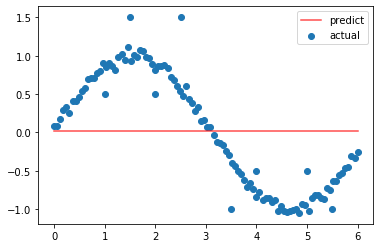

2 回目
平均二乗誤差 0.354


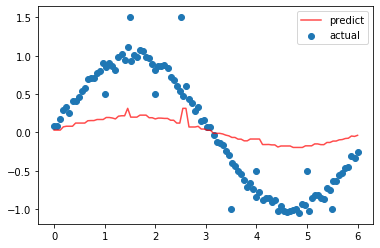

3 回目
平均二乗誤差 0.2378


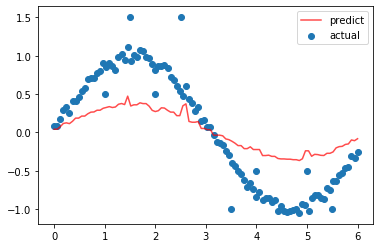

10 回目
平均二乗誤差 0.0154


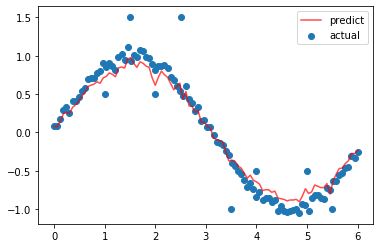

50 回目
平均二乗誤差 0.0012


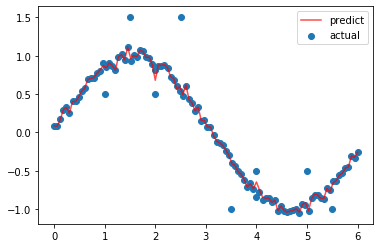

100 回目
平均二乗誤差 0.001


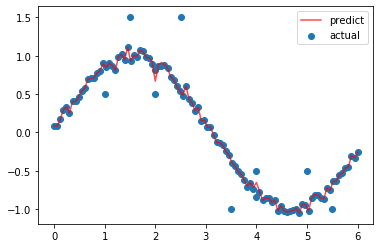

In [7]:
x_grid = np.linspace(min(X), max(X), 100)
model = DecisionTreeRegressor()

np.random.seed(0)

for i in range(n):
    #1回目は、平均を予測値とする
    if i == 0:
        y_pred = [np.mean(y) for _ in range(len(X))]
        y_grid = [np.mean(y) for _ in range(len(x_grid))]
    #2回目以降、ズレに対してランダムフォレストを作成する
    else:
        # 決定木で埋めるズレ(negative gradients)
        hm = get_loss_negative_gradients(y, y_pred)
        #Xとtargetを結合し、学習に使うための一部のみ抽出する
        X_target = np.array(
            random.sample(
                list(zip(X, hm)),
                round(len(X) * sample_r))
        )
        #学習
        model.fit(X_target[:, 0].reshape(-1, 1), X_target[:, 1])
        # 前回の予測に、今回のモデルを学習率掛けながら足す
        y_pred +=  learn_r * model.predict(X.reshape(-1, 1))
        y_grid +=  learn_r * model.predict(x_grid.reshape(-1, 1))
    #グラフとか表示する
    if i == 0 or i == 1 or i == 2 or i == 9 or i == 49 or i == 99:
        print(i+1, "回目")
        print("平均二乗誤差", round(get_loss(y, y_pred) / len(y), 4))
        fig, ax = plt.subplots(1, 1)
        ax.scatter(X, y, label="actual")
        ax.plot(x_grid, y_grid, color="red", alpha=0.7, label="predict")
        ax.legend()
        plt.show()

# 勾配ブースティング（scikit-learn）

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse

平均二乗誤差 0.0044


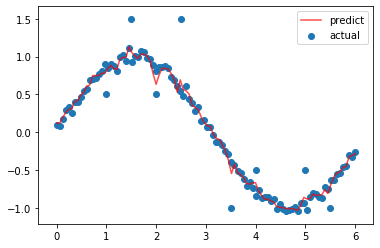

In [9]:
model = GradientBoostingRegressor(
    loss='ls',
    learning_rate=learn_r,
    n_estimators=n,
    subsample=sample_r,
    random_state=0
)
model.fit(X.reshape(-1, 1), y)

y_pred = model.predict(X.reshape(-1, 1))
y_grid = model.predict(x_grid.reshape(-1, 1))

print("平均二乗誤差", round(mse(y, y_pred), 4))
fig, ax = plt.subplots(1, 1)
ax.plot(x_grid, y_grid, color="red", alpha=0.7, label="predict")
ax.scatter(X, y, label="actual")
ax.legend()
plt.show()

# ランダムフォレストの場合

In [10]:
from sklearn.metrics import mean_squared_error as mse #二乗誤差求める関数
from sklearn.ensemble import RandomForestRegressor #ランダムフォレスト

平均二乗誤差 0.0058


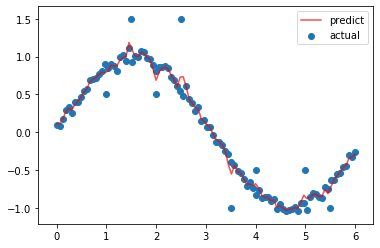

In [11]:
model = RandomForestRegressor()
model.fit(X.reshape(-1, 1), y)

y_pred = model.predict(X.reshape(-1, 1))
y_grid = model.predict(x_grid.reshape(-1, 1))

print("平均二乗誤差", round(mse(y, y_pred), 4))
fig, ax = plt.subplots(1, 1)
ax.plot(x_grid, y_grid, color="red", alpha=0.7, label="predict")
ax.scatter(X, y, label="actual")
ax.legend()
plt.show()